In [2]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Install required packages
#%pip install numpy pandas xarray geopandas matplotlib shapely scipy scikit-learn 

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import snowdroughtindex package
from snowdroughtindex.core import sswei

In [3]:
# Configuration
config = {
    'SWEI_input_dir': project_root / 'data' / 'output_data' /  '1980_2024' / 'comparison'/ 'For_SWEI_calculation.csv',
    'SPI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'monthly_SPI_2005_unstacked.csv',
    'SnoDRI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'monthly_SnoDRI_2005_unstacked.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles' / 'BowRiverBasin' / 'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024' / 'comparison',
}

# Create output directories
config['output_dir'].mkdir(parents=True, exist_ok=True)
config['plots'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


# Calculate monthly SWEI for 2005

In [4]:
# load SWEI input data
swe_df = pd.read_csv(config['SWEI_input_dir'], parse_dates=['date'])
print(f"Loaded SWEI input data from: {config['SWEI_input_dir']}")

#drop columns if they exist
cols_to_drop = ['time', 'lon','lat']
swe_df = swe_df.drop(columns=[col for col in cols_to_drop if col in swe_df.columns], errors='ignore')

# add month column
swe_df['month'] = swe_df['date'].dt.month

# select data for season 2005 (Oct 2005 to Sep 2006)
swe_df = swe_df[(swe_df['date'] >= '2005-10-01') & (swe_df['date'] < '2006-10-01')]


display(swe_df.head())

Loaded SWEI input data from: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\For_SWEI_calculation.csv


,date,Grid_id,SWE,Elevation_Category,season_year,daily_SWE_change,month
6081,2005-10-01,1,11.274902,2000_2500m,2005,3.475098,10
6082,2005-10-02,1,14.750000,2000_2500m,2005,0.125000,10
6083,2005-10-03,1,14.875000,2000_2500m,2005,0.750000,10
6084,2005-10-04,1,15.625000,2000_2500m,2005,0.000000,10
6085,2005-10-05,1,14.875000,2000_2500m,2005,0.000000,10


In [5]:
# perturb daily_SWE_change for both subsets
swe_df['perturb_SWE'] = sswei.perturb_zeros(swe_df['daily_SWE_change'])

display(swe_df.head())

,date,Grid_id,SWE,Elevation_Category,season_year,daily_SWE_change,month,perturb_SWE
6081,2005-10-01,1,11.274902,2000_2500m,2005,3.475098,10,3.475098
6082,2005-10-02,1,14.750000,2000_2500m,2005,0.125000,10,0.125000
6083,2005-10-03,1,14.875000,2000_2500m,2005,0.750000,10,0.750000
6084,2005-10-04,1,15.625000,2000_2500m,2005,0.000000,10,0.000009
6085,2005-10-05,1,14.875000,2000_2500m,2005,0.000000,10,0.000015


In [6]:
# integrate perturb_SWE by Grid_id, season_year, month
def _integrate_perturb(group):
    group = group.sort_values('date')
    if group.shape[0] < 2:
        # single observation -> zero-area (or you could set to NaN)
        return pd.Series({
            'integrated_perturb_SWE': 0.0,
            'n_obs': int(group.shape[0]),
            'start_date': group['date'].iloc[0],
            'end_date': group['date'].iloc[0]
        })
    # x in days since first observation
    x = (group['date'] - group['date'].iloc[0]).dt.total_seconds() / 86400.0
    y = group['perturb_SWE'].values
    area = trapz(y, x)
    return pd.Series({
        'integrated_perturb_SWE': float(area),
        'n_obs': int(group.shape[0]),
        'start_date': group['date'].iloc[0],
        'end_date': group['date'].iloc[-1]
    })

perturb_integrated = swe_df.groupby(['Grid_id', 'season_year', 'month']).apply(_integrate_perturb).reset_index()

#keep elevation category
elevation_mapping = swe_df[['Grid_id', 'Elevation_Category']].drop_duplicates()

perturb_integrated = perturb_integrated.merge(elevation_mapping, on='Grid_id', how='left')

display(perturb_integrated.head())

,Grid_id,season_year,month,integrated_perturb_SWE,n_obs,start_date,end_date,Elevation_Category
0,1,2005,1,41.125020,31,2006-01-01,2006-01-31,2000_2500m
1,1,2005,2,25.062580,28,2006-02-01,2006-02-28,2000_2500m
2,1,2005,3,13.312630,31,2006-03-01,2006-03-31,2000_2500m
3,1,2005,4,21.563165,30,2006-04-01,2006-04-30,2000_2500m
4,1,2005,5,23.425037,31,2006-05-01,2006-05-31,2000_2500m


In [7]:
# 3. Gringorten plotting position calculation
# Apply gringorten_probabilities grouped by coordinate_id
perturb_integrated['gringorten_probability'] = perturb_integrated.groupby('Grid_id')['integrated_perturb_SWE'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(perturb_integrated)

,Grid_id,season_year,month,integrated_perturb_SWE,n_obs,start_date,end_date,Elevation_Category,gringorten_probability
0,1,2005,1,41.125020,31,2006-01-01,2006-01-31,2000_2500m,0.931034
1,1,2005,2,25.062580,28,2006-02-01,2006-02-28,2000_2500m,0.561576
2,1,2005,3,13.312630,31,2006-03-01,2006-03-31,2000_2500m,0.068966
3,1,2005,4,21.563165,30,2006-04-01,2006-04-30,2000_2500m,0.192118
4,1,2005,5,23.425037,31,2006-05-01,2006-05-31,2000_2500m,0.438424
...,...,...,...,...,...,...,...,...,...
2051,257,2005,4,0.130556,30,2006-04-01,2006-04-30,500_1000m,0.192118
2052,257,2005,5,0.000240,31,2006-05-01,2006-05-31,500_1000m,0.068966
2053,257,2005,10,0.251341,31,2005-10-01,2005-10-31,500_1000m,0.315271
2054,257,2005,11,3.626030,30,2005-11-01,2005-11-30,500_1000m,0.438424


In [8]:
#4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
perturb_integrated['SSWEI'] = perturb_integrated.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(perturb_integrated)

,Grid_id,season_year,month,integrated_perturb_SWE,n_obs,start_date,end_date,Elevation_Category,gringorten_probability,SSWEI
0,1,2005,1,41.125020,31,2006-01-01,2006-01-31,2000_2500m,0.931034,1.483540
1,1,2005,2,25.062580,28,2006-02-01,2006-02-28,2000_2500m,0.561576,0.154967
2,1,2005,3,13.312630,31,2006-03-01,2006-03-31,2000_2500m,0.068966,-1.483540
3,1,2005,4,21.563165,30,2006-04-01,2006-04-30,2000_2500m,0.192118,-0.870117
4,1,2005,5,23.425037,31,2006-05-01,2006-05-31,2000_2500m,0.438424,-0.154967
...,...,...,...,...,...,...,...,...,...,...
2051,257,2005,4,0.130556,30,2006-04-01,2006-04-30,500_1000m,0.192118,-0.870117
2052,257,2005,5,0.000240,31,2006-05-01,2006-05-31,500_1000m,0.068966,-1.483540
2053,257,2005,10,0.251341,31,2005-10-01,2005-10-31,500_1000m,0.315271,-0.480964
2054,257,2005,11,3.626030,30,2005-11-01,2005-11-30,500_1000m,0.438424,-0.154967


In [9]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = perturb_integrated.groupby(['month', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='month', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,month,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1,0.383165,-0.058331,0.741496,0.565330
1,2,1.377912,0.629970,-0.051821,1.025301
2,3,0.079939,-0.055317,-0.921746,1.138078
3,4,-0.370709,-0.157756,0.466893,-0.853512
4,5,-1.375807,-0.578864,-0.036872,-1.366109
5,10,-0.730352,-0.146878,-0.187358,-0.615001
6,11,0.938935,1.084783,0.709481,0.119749
7,12,-0.303084,-0.717607,-0.720074,-0.013836


In [10]:
# load SPI and SnoDRI data
spi_df = pd.read_csv(config['SPI_dir'])
snodri_df = pd.read_csv(config['SnoDRI_dir'])

display(spi_df.head())
display(snodri_df.head())

,month,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
0,10,-0.052669,-0.013912,0.549937,0.393079
1,11,0.131721,0.276616,-0.712863,-0.074196
2,12,-1.209708,-1.036021,-1.424022,-0.908139
3,1,-0.349224,-0.382049,0.390312,0.233379
4,2,0.466405,0.035853,-0.213536,0.368217


,month,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,10,2.769762,2.605304,2.539578,3.561950
1,11,1.668646,1.757924,1.619876,2.093976
2,12,-0.213678,-0.221801,-0.375518,0.430844
3,1,-0.530610,-0.560962,-0.452359,0.360861
4,2,-1.257527,-1.228690,-1.278078,-0.907150


In [11]:
# Plot SSWEI, SPI, and SnoDRI by elevation categories
merged = average_SSWEI_per_year.merge(spi_df, on='month').merge(snodri_df, on='month')
display(merged.head())

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
0,1,0.383165,-0.058331,0.741496,0.565330,-0.349224,-0.382049,0.390312,0.233379,-0.530610,-0.560962,-0.452359,0.360861
1,2,1.377912,0.629970,-0.051821,1.025301,0.466405,0.035853,-0.213536,0.368217,-1.257527,-1.228690,-1.278078,-0.907150
2,3,0.079939,-0.055317,-0.921746,1.138078,-0.891061,-1.640496,-0.784207,0.422021,-1.086706,-1.364560,-1.290957,-0.449877
3,4,-0.370709,-0.157756,0.466893,-0.853512,-0.159193,-0.427991,0.554801,0.658789,-0.179885,-0.390661,-0.369682,0.733632
4,5,-1.375807,-0.578864,-0.036872,-1.366109,-0.376534,-0.464000,-0.473230,0.435772,0.660790,0.512511,0.323887,1.531504


In [13]:
# display october data
october_data = merged[merged['month'] == 10]
display(october_data)

,month,1000_1500m,1500_2000m,2000_2500m,500_1000m,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI,1000_1500m_SnoDRI,1500_2000m_SnoDRI,2000_2500m_SnoDRI,500_1000m_SnoDRI
5,10,-0.730352,-0.146878,-0.187358,-0.615001,-0.052669,-0.013912,0.549937,0.393079,2.769762,2.605304,2.539578,3.56195


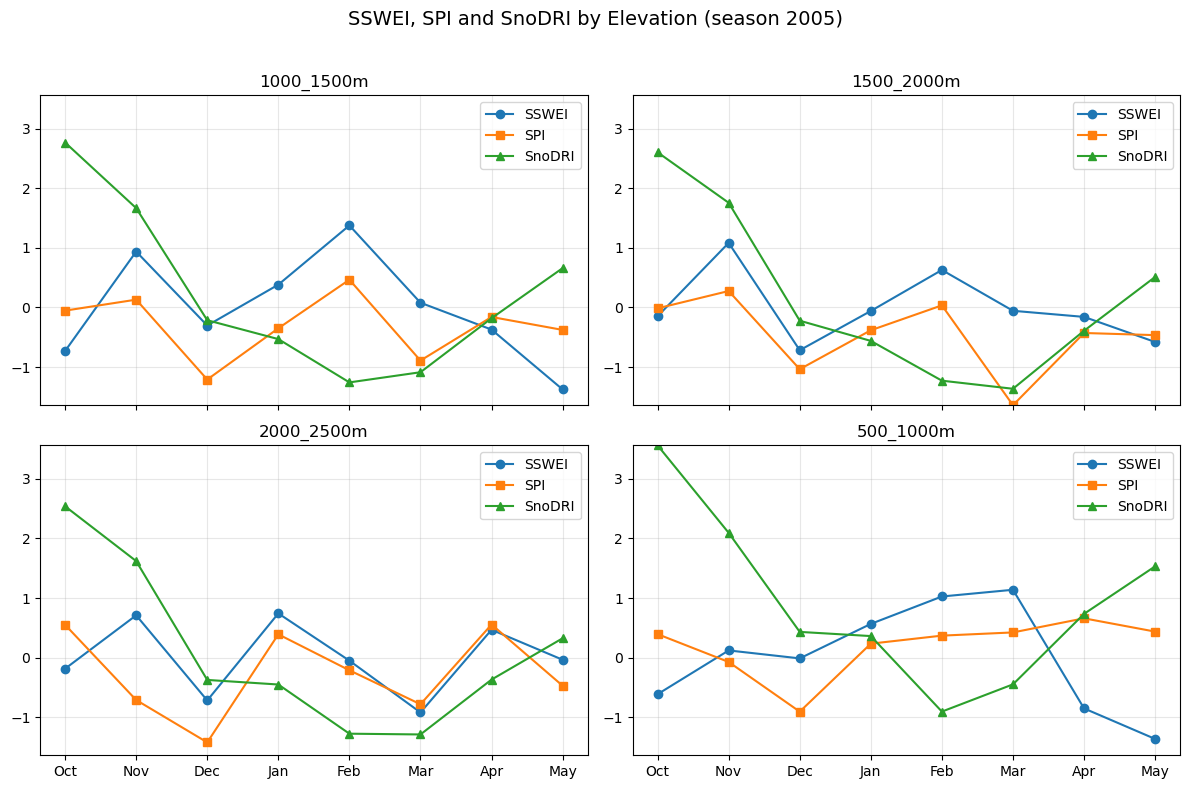

In [12]:
# Plot merged for each elevation (fix x-axis ordering by using ordinal positions)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
try:
    merged_sorted = merged.set_index('month').loc[month_order].reset_index()
except Exception:
    merged_sorted = merged.copy()

# derive elevation category column names from merged_sorted (those without _SPI/_SnoDRI suffix)
elevations = [c for c in merged_sorted.columns if c != 'month' and not c.endswith('_SPI') and not c.endswith('_SnoDRI')]
# ensure consistent ordering (you can customize if needed)
elevations = sorted(elevations)

# output file for saving the figure
out_file = config['plots'] / 'comparison_2005_by_elevation.png'

fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes2 = axes2.flatten()
colors = {'SSWEI': 'tab:blue', 'SPI': 'tab:orange', 'SnoDRI': 'tab:green'}

# use integer x positions so months are plotted in the specified order
x = np.arange(len(merged_sorted))
month_labels = pd.to_datetime(merged_sorted['month'].astype(str), format='%m').dt.strftime('%b')

for i, elev in enumerate(elevations):
    ax = axes2[i]
    ax.plot(x, merged_sorted[elev], marker='o', color=colors['SSWEI'], label='SSWEI')
    ax.plot(x, merged_sorted[f'{elev}_SPI'], marker='s', color=colors['SPI'], label='SPI')
    ax.plot(x, merged_sorted[f'{elev}_SnoDRI'], marker='^', color=colors['SnoDRI'], label='SnoDRI')
    ax.set_title(elev)
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.grid(alpha=0.3)
    ax.legend()

# same y-axis limits for all subplots
ymin = min(merged_sorted[elev].min() for elev in elevations + [f'{elev}_SPI' for elev in elevations] + [f'{elev}_SnoDRI' for elev in elevations])
ymax = max(merged_sorted[elev].max() for elev in elevations + [f'{elev}_SPI' for elev in elevations] + [f'{elev}_SnoDRI' for elev in elevations])
for ax in axes2:
    ax.set_ylim(ymin, ymax)

# hide any remaining axes
for j in range(len(elevations), len(axes2)):
    axes2[j].set_visible(False)

fig2.suptitle('SSWEI, SPI and SnoDRI by Elevation (season 2005)', fontsize=14)
fig2.tight_layout(rect=[0, 0, 1, 0.96])
fig2.savefig(out_file, dpi=300)
plt.show()